In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os.path
import os,re
import glob
import pprint
import pathlib
import threading
import time
import joblib
from pandas import DataFrame
from datetime import datetime,timedelta
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
from tensorflow import keras
from sklearn.utils import shuffle

In [57]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/Hancom Gothic Regular.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

In [58]:
plt.rcParams['axes.unicode_minus'] = False
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'")

## FFT

In [9]:
def df_fft(df):
    n = len(df['data']) 
    k = np.arange(n)
    Fs = 1/0.00025 # 1초에 반복되는 횟수 
    T = n/Fs # end of time 
    freq = k/T
    freq = freq[range(int(n/2))]
    Y = np.fft.fft(df['data']) # df1의 시간영역의 데이터에서 주파수 성분 찾게됨 
    Y = Y[range(int(n/2))]/n
    df = DataFrame(abs(Y),freq).reset_index()
    df.columns=['freq','data']
    return df

In [137]:
n = len(ex2['data']) 
k = np.arange(n)
freq = k/3
freq
k

array([    0,     1,     2, ..., 11997, 11998, 11999])

In [12]:
# 학습용 데이터 생성  
def model_data(Kw,Type,Num):
    dir_path = "D:/Training/vibration" 
    files = glob.glob(os.path.join(dir_path+'/'+Kw+'/*/'+Type,'*.*'),recursive=True)[:Num]
    pieces = []
#     files_arr = []
    for i in range(len(files)):
        file = files[i]
#         files_arr.append(file)
#         file = shuffle(files_arr)
#         frame = pd.read_csv(file[i],skiprows=8) 
        frame = pd.read_csv(file,skiprows=8) 
        frame.drop(frame.columns[[2]],axis=1,inplace=True)
        frame.columns=['time','data']
        frame = df_fft(frame)
        frame.set_index('freq',inplace=True)
        pieces.append(frame.T)
        df = pd.concat(pieces,ignore_index=True)
        df['type']= Type
        df['kw'] = Kw
    return df

In [102]:
# 일반 모양 데이터 
def making_data(Kw,Type,Num):
    dir_path = "D:/Training/vibration" 
    files = glob.glob(os.path.join(dir_path+'/'+Kw+'/*/'+Type,'*.*'),recursive=True)[:Num]
    pieces = []
    files_arr = []
    for i in range(len(files)):
        file = files[i]
#         files_arr.append(file)
#         file = shuffle(files_arr)
#        print(file)
        frame = pd.read_csv(file,skiprows=8) 
        frame.drop(frame.columns[[2]],axis=1,inplace=True)
        frame.columns=['time','data']
#         frame.set_index('time',inplace=True)
#        frame = df_fft(frame.T)
        pieces.append(frame)
        df = pd.concat(pieces,ignore_index=True)
    return df

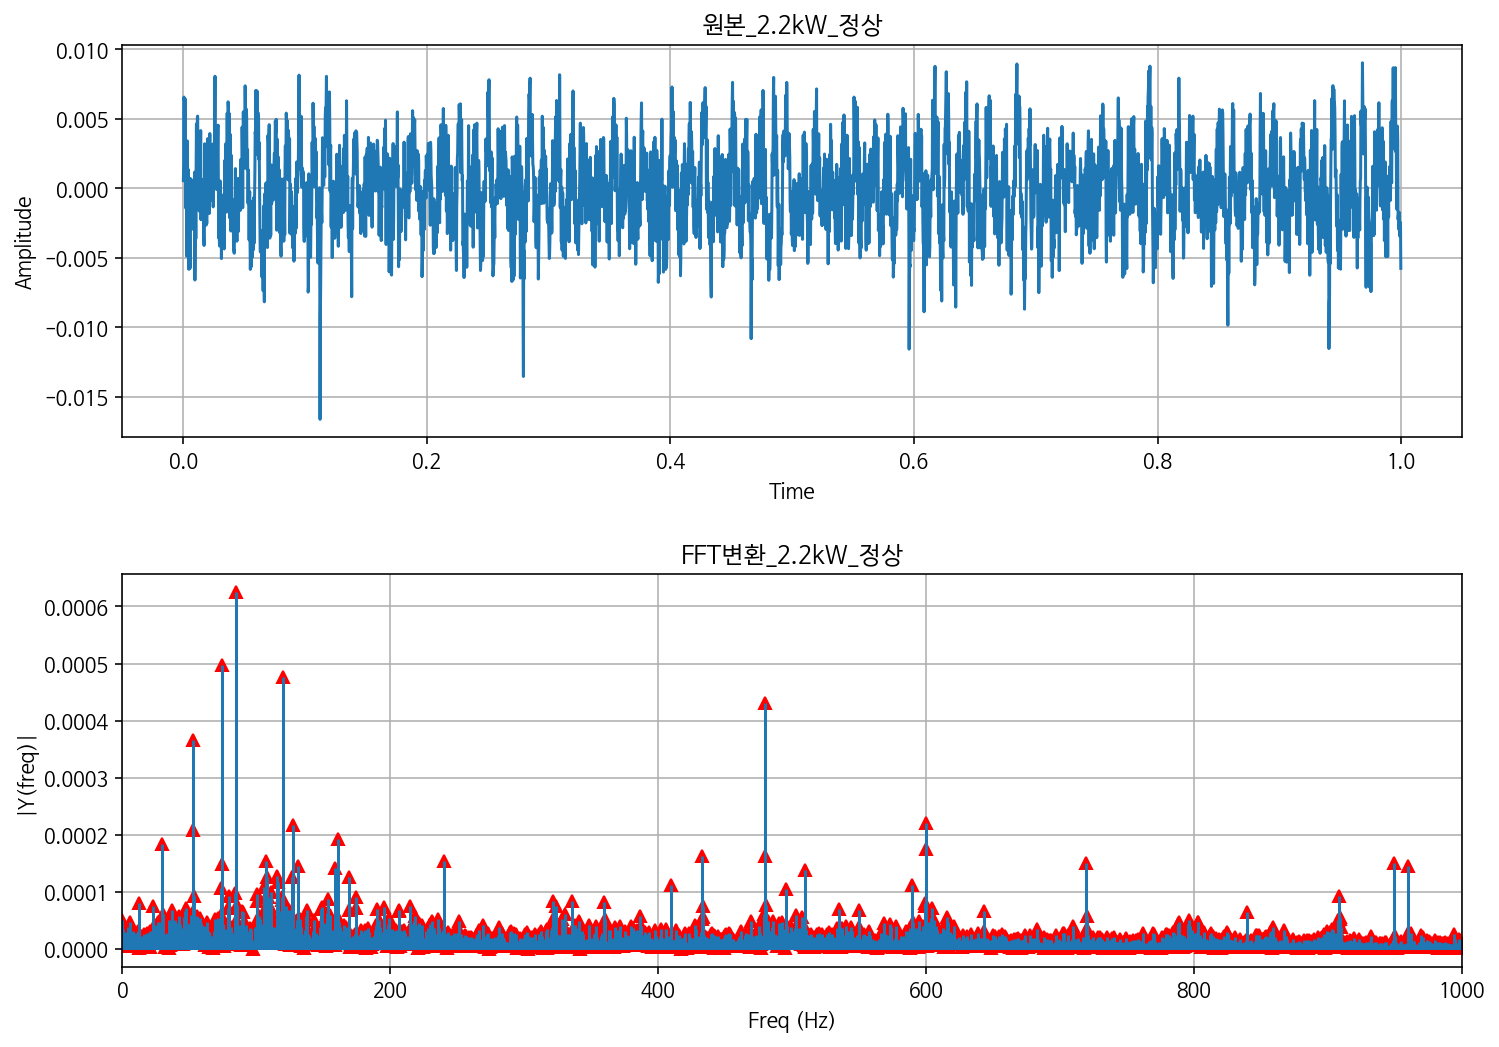

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(ex2['time'].iloc[:4000],ex2['data'].iloc[:4000])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude'); ax[0].grid(True)
ax[1].plot(ex1.freq, ex1.data, 'r', linestyle=' ', marker='^') 
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[1].vlines(ex1.freq, [0], ex1.data)
ax[1].set_xlim([0, 1000]); ax[1].grid(True)
ax[0].set_title('원본_2.2kW_정상')
ax[1].set_title('FFT변환_2.2kW_정상')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.show()

###  MCPL based on F.P.MCP

In [13]:
# 정상
kW = ['2.2kW','3.7kW','3.75kW','5.5kW','7.5kW','11kW','15kW','18.5kW','22kW','30kW','37kW','55kW']
arr = []
arr_org = []
for i in range(12):
    
    a = model_data(kW[i],'정상',500)
#     b = making_data(kW[i],'정상',5)
    arr.append(a)
    normal = pd.concat(arr)
#     arr_org.append(b)
#    a_name = ['2_2kW','3_7kW','5_5kW','7_5kW','11kW','15kW','18_5kW','22kW','55kW']
#     b_name = ['2_2kW','3_7kW','5_5kW','7_5kW','11kW','15kW','18_5kW','22kW','55kW']
#    globals()['normal{}'.format(a_name[i])]=arr[i]
#     globals()['normal_org{}'.format(b_name[i])]=arr_sp[i]

In [14]:
kW = ['2.2kW','3.7kW','5.5kW','7.5kW','11kW','15kW','18.5kW']
arr = []
for i in range(7):
    
    a = model_data(kW[i],'베어링불량',500)
#     b = making_data(kW[i],'베어링불량',5)
    arr.append(a)
    bearing = pd.concat(arr)
    print(i)

0
1
2
3
4
5
6


In [15]:
kW = ['2.2kW','3.7kW','5.5kW','11kW','15kW','22kW','55kW']
arr = []
# arr_org = []
for i in range(7):
    
    a = model_data(kW[i],'회전체불평형',500)
#     b = making_data(kW[i],'회전체불평형',5)
    arr.append(a)
    rotating = pd.concat(arr)

In [16]:
# 축정렬불량
kW = ['2.2kW','3.7kW','3.75kW','5.5kW','7.5kW','11kW','22kW','30kW','37kW']
arr = []
# arr_org=[]
for i in range(9):
    
    a = model_data(kW[i],'축정렬불량',500)
#     b = making_data(kW[i],'축정렬불량',5)
    arr.append(a)
    axis = pd.concat(arr)

In [17]:
# 벨트느슨함
kW = ['2.2kW','5.5kW','7.5kW','11kW','15kW','18.5kW','22kW','55kW']
arr = []
# arr_org = []
for i in range(8):
    
    a = model_data(kW[i],'벨트느슨함',500)
#     b = making_data(kW[i],'벨트느슨함',5)
    arr.append(a)
    belt = pd.concat(arr)

In [18]:
df_train = pd.concat([normal,bearing,axis,belt,rotating],ignore_index=True)

In [19]:
df_train

freq,0.0,0.3333333333333333,0.6666666666666666,1.0,1.3333333333333333,1.6666666666666667,2.0,2.3333333333333335,2.6666666666666665,3.0,...,1997.3333333333333,1997.6666666666667,1998.0,1998.3333333333333,1998.6666666666667,1999.0,1999.3333333333333,1999.6666666666667,type,kw
0,0.000005,0.000012,0.000016,0.000006,0.000008,0.000003,0.000005,0.000006,0.000010,0.000005,...,0.000008,0.000006,0.000002,0.000001,8.984613e-07,0.000002,0.000002,0.000003,정상,2.2kW
1,0.000006,0.000014,0.000014,0.000004,0.000012,0.000015,0.000013,0.000015,0.000030,0.000016,...,0.000004,0.000005,0.000004,0.000003,6.144740e-06,0.000006,0.000008,0.000002,정상,2.2kW
2,0.000015,0.000014,0.000012,0.000014,0.000011,0.000020,0.000016,0.000017,0.000019,0.000005,...,0.000002,0.000006,0.000010,0.000007,1.192897e-05,0.000006,0.000003,0.000006,정상,2.2kW
3,0.000016,0.000021,0.000009,0.000007,0.000010,0.000014,0.000006,0.000012,0.000010,0.000020,...,0.000002,0.000002,0.000004,0.000008,3.363697e-06,0.000001,0.000002,0.000003,정상,2.2kW
4,0.000006,0.000010,0.000009,0.000002,0.000025,0.000017,0.000011,0.000010,0.000008,0.000012,...,0.000003,0.000006,0.000002,0.000005,6.690206e-06,0.000001,0.000007,0.000002,정상,2.2kW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21495,0.000031,0.000045,0.000084,0.000062,0.000319,0.000147,0.000233,0.000197,0.000112,0.000237,...,0.000318,0.000102,0.000222,0.000149,1.460147e-04,0.000218,0.000064,0.000102,회전체불평형,55kW
21496,0.000029,0.000033,0.000100,0.000142,0.000295,0.000129,0.000147,0.000122,0.000496,0.000114,...,0.000168,0.000248,0.000050,0.000106,1.162380e-04,0.000102,0.000085,0.000099,회전체불평형,55kW
21497,0.000054,0.000121,0.000114,0.000088,0.000088,0.000218,0.000052,0.000284,0.000479,0.000452,...,0.000036,0.000216,0.000306,0.000163,1.562143e-04,0.000149,0.000230,0.000148,회전체불평형,55kW
21498,0.000078,0.000138,0.000144,0.000183,0.000095,0.000190,0.000122,0.000086,0.000081,0.000258,...,0.000076,0.000184,0.000155,0.000179,2.998549e-04,0.000221,0.000115,0.000099,회전체불평형,55kW


In [20]:
df_train['kw_type'] = df_train['type']+df_train['kw']

In [21]:
df_train.drop(columns=['type','kw'],axis=1)

freq,0.0,0.3333333333333333,0.6666666666666666,1.0,1.3333333333333333,1.6666666666666667,2.0,2.3333333333333335,2.6666666666666665,3.0,...,1997.0,1997.3333333333333,1997.6666666666667,1998.0,1998.3333333333333,1998.6666666666667,1999.0,1999.3333333333333,1999.6666666666667,kw_type
0,0.000005,0.000012,0.000016,0.000006,0.000008,0.000003,0.000005,0.000006,0.000010,0.000005,...,0.000002,0.000008,0.000006,0.000002,0.000001,8.984613e-07,0.000002,0.000002,0.000003,정상2.2kW
1,0.000006,0.000014,0.000014,0.000004,0.000012,0.000015,0.000013,0.000015,0.000030,0.000016,...,0.000007,0.000004,0.000005,0.000004,0.000003,6.144740e-06,0.000006,0.000008,0.000002,정상2.2kW
2,0.000015,0.000014,0.000012,0.000014,0.000011,0.000020,0.000016,0.000017,0.000019,0.000005,...,0.000004,0.000002,0.000006,0.000010,0.000007,1.192897e-05,0.000006,0.000003,0.000006,정상2.2kW
3,0.000016,0.000021,0.000009,0.000007,0.000010,0.000014,0.000006,0.000012,0.000010,0.000020,...,0.000003,0.000002,0.000002,0.000004,0.000008,3.363697e-06,0.000001,0.000002,0.000003,정상2.2kW
4,0.000006,0.000010,0.000009,0.000002,0.000025,0.000017,0.000011,0.000010,0.000008,0.000012,...,0.000004,0.000003,0.000006,0.000002,0.000005,6.690206e-06,0.000001,0.000007,0.000002,정상2.2kW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21495,0.000031,0.000045,0.000084,0.000062,0.000319,0.000147,0.000233,0.000197,0.000112,0.000237,...,0.000072,0.000318,0.000102,0.000222,0.000149,1.460147e-04,0.000218,0.000064,0.000102,회전체불평형55kW
21496,0.000029,0.000033,0.000100,0.000142,0.000295,0.000129,0.000147,0.000122,0.000496,0.000114,...,0.000156,0.000168,0.000248,0.000050,0.000106,1.162380e-04,0.000102,0.000085,0.000099,회전체불평형55kW
21497,0.000054,0.000121,0.000114,0.000088,0.000088,0.000218,0.000052,0.000284,0.000479,0.000452,...,0.000194,0.000036,0.000216,0.000306,0.000163,1.562143e-04,0.000149,0.000230,0.000148,회전체불평형55kW
21498,0.000078,0.000138,0.000144,0.000183,0.000095,0.000190,0.000122,0.000086,0.000081,0.000258,...,0.000096,0.000076,0.000184,0.000155,0.000179,2.998549e-04,0.000221,0.000115,0.000099,회전체불평형55kW


### One-hot encoding

In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
data_cat = ohe.fit_transform(df_train[['kw_type']])
new_data = pd.concat([df_train.drop(columns=['kw_type']),pd.DataFrame(data_cat, columns=['type_' + str(col) for col in ohe.categories_[0]])], axis=1)

import joblib

joblib.dump(ohe, "ohe_type.pkl")

['ohe_type.pkl']

In [110]:
new_data.to_csv('new_data.csv')